# Bayesian Linear Regression (25 marks)

In [1]:
# Import Libraries
import os
import pandas as pd  # use pandas to load data from CSV files
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, zscore
from sklearn.preprocessing import StandardScaler
import pymc as pm
import arviz as az
import seaborn as sns

# Suppress the BLAS warning
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning, module="pytensor.tensor.blas")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Loading data
data_path = "seoul_bike_sharing_demand"

files = os.listdir(data_path)
print(files)

['SeoulBikeData.csv']


In [3]:
# Loading data

# Read the CSV file into a pandas DataFrame
seoul_bike_data = pd.read_csv(os.path.join(data_path, 'SeoulBikeData.csv'))

# Display the first few rows of the DataFrame
print(seoul_bike_data.shape)
print(type(seoul_bike_data))
print(seoul_bike_data.head())

(8760, 14)
<class 'pandas.core.frame.DataFrame'>
         Date  Rented Bike Count  Hour  Temperature(C)  Humidity(%)  \
0  01/12/2017                254     0            -5.2           37   
1  01/12/2017                204     1            -5.5           38   
2  01/12/2017                173     2            -6.0           39   
3  01/12/2017                107     3            -6.2           40   
4  01/12/2017                 78     4            -6.0           36   

   Wind speed (m/s)  Visibility (10m)  Dew point temperature(C)  \
0               2.2              2000                     -17.6   
1               0.8              2000                     -17.6   
2               1.0              2000                     -17.7   
3               0.9              2000                     -17.6   
4               2.3              2000                     -18.6   

   Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm) Seasons     Holiday  \
0                      0.0           0.0  

## Task 10

In [4]:
# print(seoul_bike_data.dropna().shape) # No invalid data: (8760, 14)
# print(seoul_bike_data['Rented Bike Count'].mean())
seoul_bike_data.head()

,Date,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [5]:
# seoul_bike_data.select_dtypes(include='number')
print(np.unique(seoul_bike_data['Seasons']))
print(np.unique(seoul_bike_data['Holiday']))
print(np.unique(seoul_bike_data['Functioning Day']))
# coordinates = np.argwhere(seoul_bike_data['Functioning Day'].to_numpy() == 'No')
# coordinates = np.argwhere(seoul_bike_data['Holiday'].to_numpy() == 'Holiday')
# coordinates = np.argwhere(seoul_bike_data['Seasons'].to_numpy() == 'Summer')
# coordinates

['Autumn' 'Spring' 'Summer' 'Winter']
['Holiday' 'No Holiday']
['No' 'Yes']


In [6]:
# Define a mapping for the columns needing changing

# Ordered in ascending order of average temperature (Winter (Coldest): 0, Summer (Hottest): 3)
seasons_mapping = {'Winter': 0, 'Autumn': 1, 'Spring': 2, 'Summer': 3}
holiday_mapping = {'No Holiday': 0, 'Holiday': 1}
functioning_day_mapping = {'No': 0, 'Yes': 1}

# Map the values in the "Seasons" column to numeric values
seoul_bike_data['Seasons'] = seoul_bike_data['Seasons'].map(seasons_mapping)
seoul_bike_data['Holiday'] = seoul_bike_data['Holiday'].map(holiday_mapping)
seoul_bike_data['Functioning Day'] = seoul_bike_data['Functioning Day'].map(functioning_day_mapping)

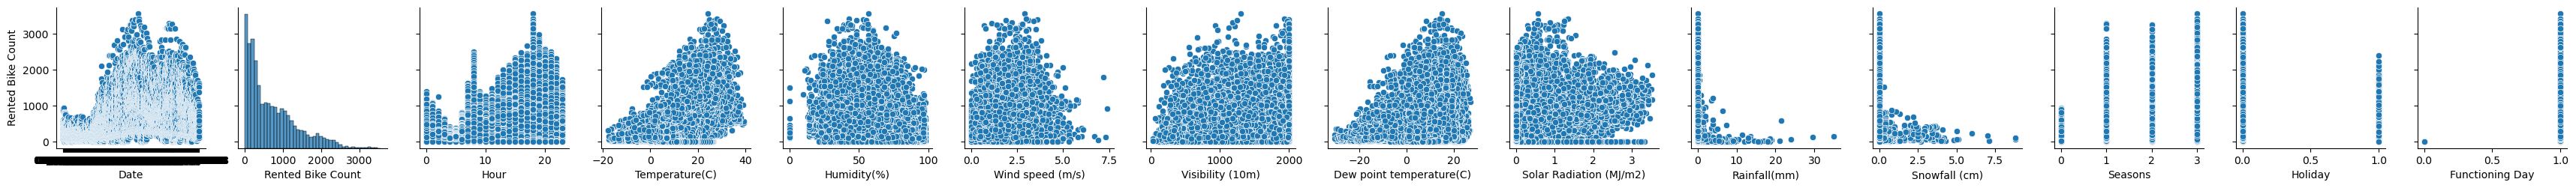

In [7]:
# Display the first few rows of the DataFrame with the updated "Seasons" column
# print(seoul_bike_data.tail())
# Visualize Data
import warnings
# Suppress FutureWarning from seaborn
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.pairplot(seoul_bike_data,
            x_vars=list(seoul_bike_data.columns),
            y_vars=["Rented Bike Count"],)
plt.show()

# list(seoul_bike_data.columns)

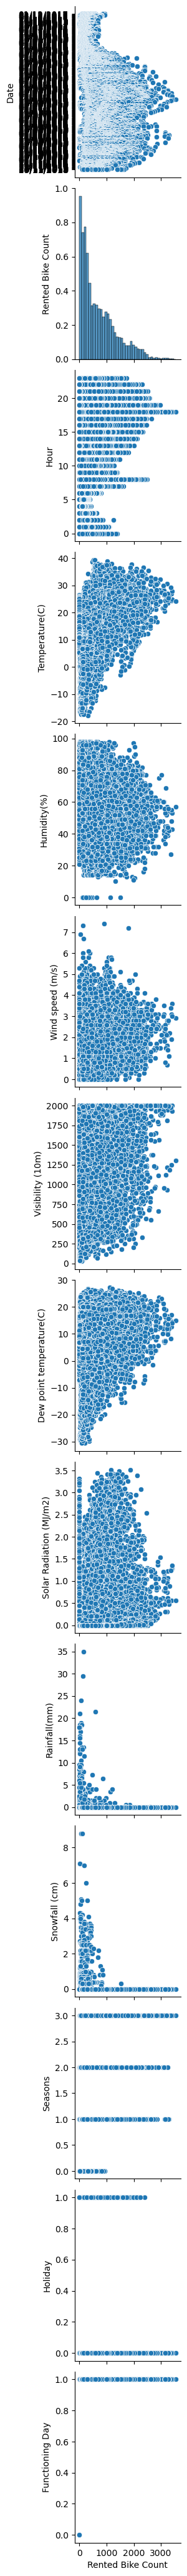

In [8]:
# Create the pair plot with the specified figure size and aspect
sns.pairplot(seoul_bike_data,
             x_vars=["Rented Bike Count"],
             y_vars=list(seoul_bike_data.columns),
            height=3)

# Show the plot
plt.show()

## Create a new dataset from the original downloaded dataset that is suitable for Bayesian Linear Regression (BLR)

In [9]:
# Dropping the columns
# Replace the column names that have to be dropped
columns_to_drop = ['Date', 'Rented Bike Count','Humidity(%)', 'Wind speed (m/s)', 'Solar Radiation (MJ/m2)']


x_data = seoul_bike_data.drop(columns=columns_to_drop)
# x_data = x_data.to_numpy()
y_data = seoul_bike_data['Rented Bike Count']

In [10]:
print("Means:")
print(x_data.mean())
print()
print('Rented Bike Count\t', y_data.mean())

Means:
Hour                          11.500000
Temperature(C)                12.882922
Visibility (10m)            1436.825799
Dew point temperature(C)       4.073813
Rainfall(mm)                   0.148687
Snowfall (cm)                  0.075068
Seasons                        1.509589
Holiday                        0.049315
Functioning Day                0.966324
dtype: float64

Rented Bike Count	 704.6020547945205


In [11]:
# Scale the data as it takes too long to run ~40 minutes
scaler = StandardScaler()

x_data_scaled = scaler.fit_transform(x_data)
print(x_data.head())
print()
print("Means:")
print(np.mean(x_data_scaled, axis=0))
print()
print("Variance:")
print(np.var(x_data_scaled, axis=0))
print()
# print(x_data.shape[0])
# print()
# print(y_data.values)
print(x_data.shape)
print(x_data_scaled.shape)
x_data_scaled[:,0]

   Hour  Temperature(C)  Visibility (10m)  Dew point temperature(C)  \
0     0            -5.2              2000                     -17.6   
1     1            -5.5              2000                     -17.6   
2     2            -6.0              2000                     -17.7   
3     3            -6.2              2000                     -17.6   
4     4            -6.0              2000                     -18.6   

   Rainfall(mm)  Snowfall (cm)  Seasons  Holiday  Functioning Day  
0           0.0            0.0        0        0                1  
1           0.0            0.0        0        0                1  
2           0.0            0.0        0        0                1  
3           0.0            0.0        0        0                1  
4           0.0            0.0        0        0                1  

Means:
[ 2.02780461e-19  9.73346213e-17 -5.51562854e-17 -5.19117980e-17
 -1.21668277e-18  1.29779495e-17 -7.78676971e-17  1.62224369e-17
 -4.38005796e-17]

Variance

array([-1.66132477, -1.51686175, -1.37239873, ...,  1.37239873,
        1.51686175,  1.66132477])

## Task 11

In [12]:
# Run PyMC algorithm to get posterior distributions for each feature

import time

start = time.time()
num_samples = x_data_scaled.shape[0]
model = pm.Model()

with model:
    # Define priors
    intercept = pm.Normal('intercept', mu=0, sigma=20)
    Hour = pm.Normal('Hour', mu=0, sigma=20)
    Temperature = pm.Normal('Temperature(C)', mu=0, sigma=20)
    Visibility = pm.Normal('Visibility (10m)', mu=0, sigma=20)
    DewPointTemperature = pm.Normal('Dew point temperature(C)', mu=0, sigma=20)
    Rainfall = pm.Normal('Rainfall(mm)', mu=0, sigma=20)
    Snowfall = pm.Normal('Snowfall (cm)', mu=0, sigma=20)
    Seasons = pm.Normal('Seasons', mu=0, sigma=20)
    Holiday = pm.Normal('Holiday', mu=0, sigma=20)
    FunctioningDay = pm.Normal('Functioning Day', mu=0, sigma=20)
    sigma = pm.Uniform('sigma', lower=0, upper=20)

    y_est = intercept + Hour*x_data_scaled[:,0] + Temperature*x_data_scaled[:,1] + Visibility*x_data_scaled[:,2] + DewPointTemperature*x_data_scaled[:,3] + Rainfall*x_data_scaled[:,4] + Snowfall*x_data_scaled[:,5] + Seasons*Rainfall*x_data_scaled[:,6] + Holiday*Rainfall*x_data_scaled[:,7] + FunctioningDay*Rainfall*x_data_scaled[:,8]

    likelihood = pm.Normal('y', mu=y_est, sigma=sigma, observed=y_data)
    
    sampler = pm.NUTS()
    
    idata = pm.sample(num_samples, step=sampler, progressbar=True, cores=4, chains=4)

end = time.time()
print(f"Training time: {end - start}s")

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, Hour, Temperature(C), Visibility (10m), Dew point temperature(C), Rainfall(mm), Snowfall (cm), Seasons, Holiday, Functioning Day, sigma]


Sampling 4 chains for 1_000 tune and 8_760 draw iterations (4_000 + 35_040 draws total) took 608 seconds.


Training time: 625.6564009189606s


In [13]:
# Summary generated by arviz.summary

summary = az.summary(idata, round_to=2)
summary[['mean', 'sd', 'r_hat']].T

,intercept,Hour,Temperature(C),Visibility (10m),Dew point temperature(C),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,sigma
mean,704.52,196.06,517.54,47.17,-202.06,-74.22,-4.25,0.06,0.41,-1.98,20.0
sd,0.21,0.23,0.66,0.25,0.64,0.22,0.22,0.01,0.00,0.01,0.0
r_hat,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0


In [14]:
# Generate 'posterior_predictive' samples from the model
ppc_test = pm.sample_posterior_predictive(idata, model=model)


Sampling: [y]


In [15]:
# Getting R^2 Score for BLR's prediction
# R-squared is the “percent of variance explained” by the model.
data_array = ppc_test['posterior_predictive']['y'].values

reshaped_array = data_array.reshape(-1, data_array.shape[-1])
reshaped_array.shape
y_pred = reshaped_array.mean(axis=0)
# print(y_pred.shape)
# print(y_pred)
# print(ppc_test['observed_data']['y'].values)

print(az.r2_score(y_data, y_pred))

r2        0.51476
r2_std    0.00000
dtype: float64


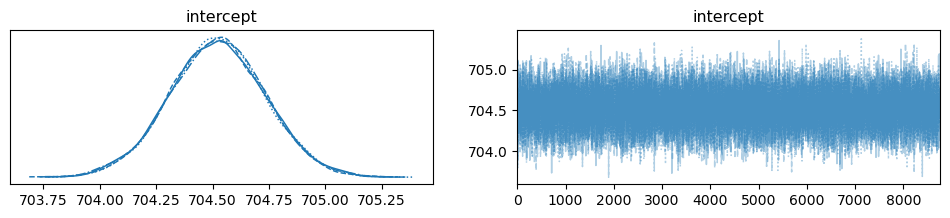

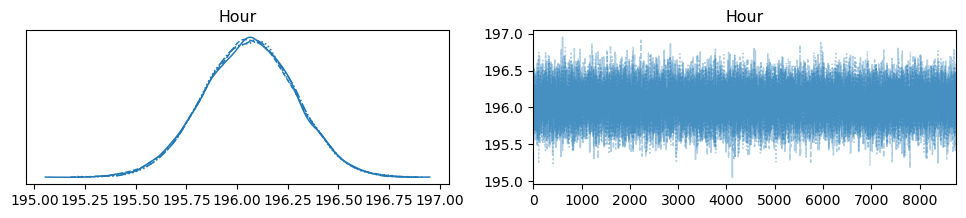

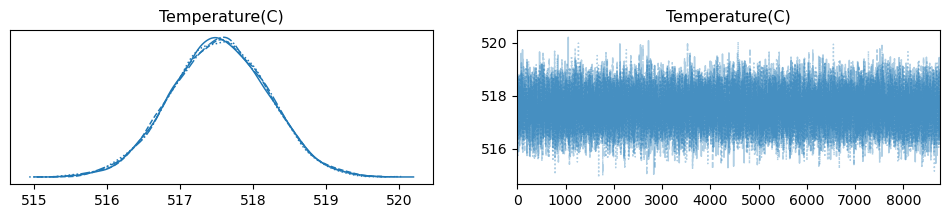

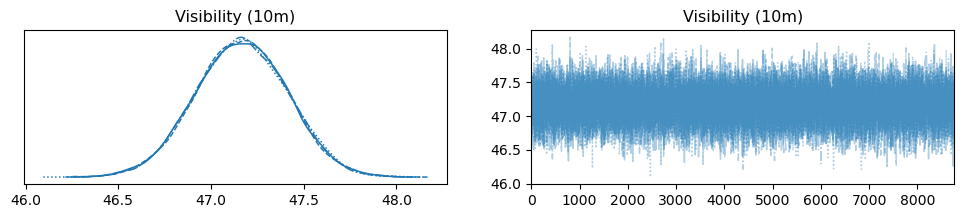

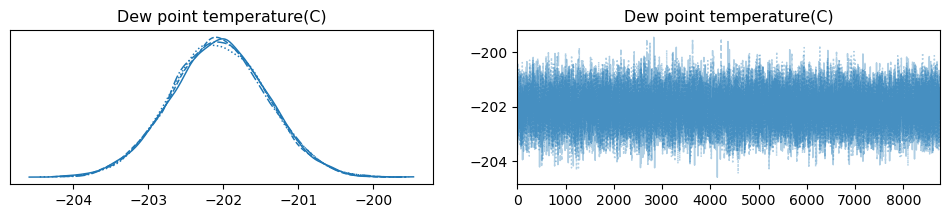

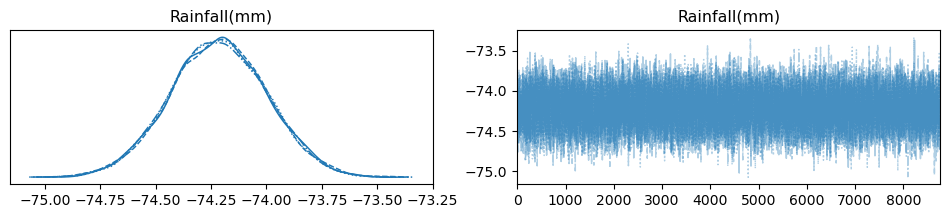

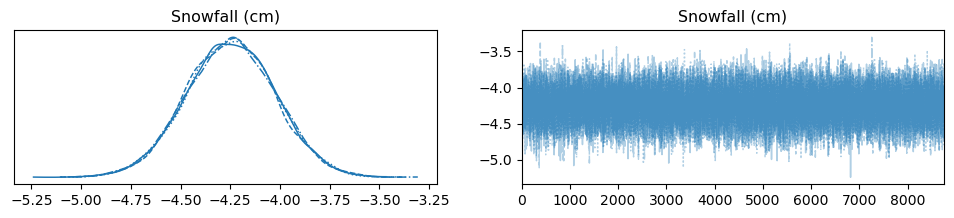

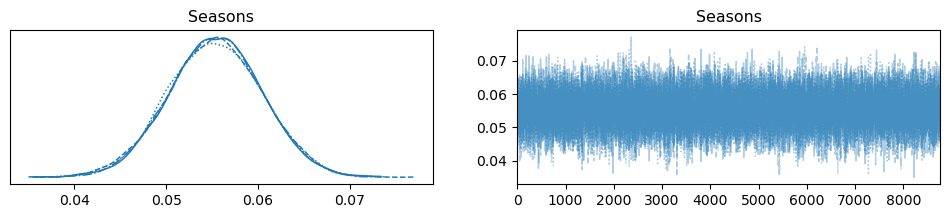

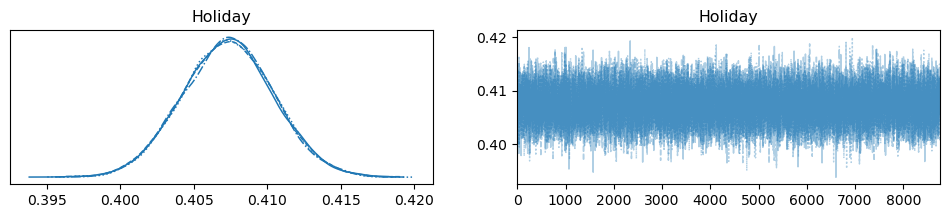

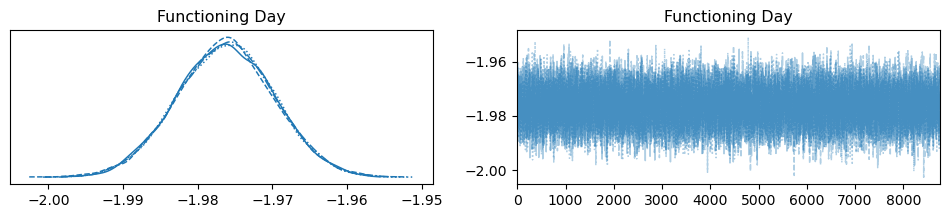

In [16]:
# Get posterior traces
trace1 = idata.posterior['intercept']
trace2 = idata.posterior['Hour']
trace3 = idata.posterior['Temperature(C)']
trace4 = idata.posterior['Visibility (10m)']
trace5 = idata.posterior['Dew point temperature(C)']
trace6 = idata.posterior['Rainfall(mm)']
trace7 = idata.posterior['Snowfall (cm)']
trace8 = idata.posterior['Seasons']
trace9 = idata.posterior['Holiday']
trace10 = idata.posterior['Functioning Day']

traces = [trace1, trace2, trace3, trace4, trace5, trace6, trace7, trace8, trace9, trace10]

# Plot each posterior distribution
'''
# Things overlap for this approach
# az.plot_trace(idata.posterior, var_names=var_names)
var_names = ["intercept", "Hour", "Temperature(C)", "Visibility (10m)", "Dew point temperature(C)", "Rainfall(mm)", "Snowfall (cm)", "Seasons", "Holiday", "Functioning Day", "sigma"]
'''
for trace in traces:
    pm.plot_trace(trace)

## Run PYMC with simpler models (less parameters) to see if performance increases / decreases removing categories that don't have a "strong" relationship with Rented Bike Count

### BLR without accounting for Visibility and Holiday

In [17]:
# Run PyMC algorithm to get posterior distributions for each feature

import time

start = time.time()
num_samples = x_data_scaled.shape[0]
model2 = pm.Model()

with model2:
    # Define priors
    intercept = pm.Normal('intercept', mu=0, sigma=20)
    Hour = pm.Normal('Hour', mu=0, sigma=20)
    Temperature = pm.Normal('Temperature(C)', mu=0, sigma=20)
    DewPointTemperature = pm.Normal('Dew point temperature(C)', mu=0, sigma=20)
    Rainfall = pm.Normal('Rainfall(mm)', mu=0, sigma=20)
    Snowfall = pm.Normal('Snowfall (cm)', mu=0, sigma=20)
    Seasons = pm.Normal('Seasons', mu=0, sigma=20)
    FunctioningDay = pm.Normal('Functioning Day', mu=0, sigma=20)
    sigma = pm.Uniform('sigma', lower=0, upper=20)

    y_est = intercept + Hour*x_data_scaled[:,0] + Temperature*x_data_scaled[:,1] + DewPointTemperature*x_data_scaled[:,3] + Rainfall*x_data_scaled[:,4] + Snowfall*x_data_scaled[:,5] + Seasons*Rainfall*x_data_scaled[:,6] + FunctioningDay*Rainfall*x_data_scaled[:,8]

    likelihood = pm.Normal('y', mu=y_est, sigma=sigma, observed=y_data)
    
    sampler = pm.NUTS()
    
    idata2 = pm.sample(num_samples, step=sampler, progressbar=True, cores=4, chains=4)

end = time.time()
print(f"Training time: {end - start}s")

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, Hour, Temperature(C), Dew point temperature(C), Rainfall(mm), Snowfall (cm), Seasons, Functioning Day, sigma]


Sampling 4 chains for 1_000 tune and 8_760 draw iterations (4_000 + 35_040 draws total) took 261 seconds.


Training time: 278.0117657184601s


In [18]:
summary2 = az.summary(idata2, round_to=2)
summary2[['mean', 'sd', 'r_hat']].T

,intercept,Hour,Temperature(C),Dew point temperature(C),Rainfall(mm),Snowfall (cm),Seasons,Functioning Day,sigma
mean,704.52,194.73,567.21,-259.09,-77.50,-5.90,-0.04,-1.88,20.0
sd,0.21,0.23,0.61,0.57,0.22,0.22,0.00,0.01,0.0
r_hat,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0


In [19]:
ppc_test2 = pm.sample_posterior_predictive(idata, model=model)

Sampling: [y]


In [20]:
data_array2 = ppc_test2['posterior_predictive']['y'].values

reshaped_array2 = data_array2.reshape(-1, data_array2.shape[-1])
reshaped_array2.shape
y_pred2 = reshaped_array2.mean(axis=0)

az.r2_score(y_data, y_pred2)

r2        0.514758
r2_std    0.000000
dtype: float64

### BLR without accounting for Visibility

In [21]:
# Run PyMC algorithm to get posterior distributions for each feature

import time

start = time.time()
num_samples = x_data_scaled.shape[0]
model3 = pm.Model()

with model3:
    # Define priors
    intercept = pm.Normal('intercept', mu=0, sigma=20)
    Hour = pm.Normal('Hour', mu=0, sigma=20)
    Temperature = pm.Normal('Temperature(C)', mu=0, sigma=20)
    # Visibility = pm.Normal('Visibility (10m)', mu=0, sigma=20)
    DewPointTemperature = pm.Normal('Dew point temperature(C)', mu=0, sigma=20)
    Rainfall = pm.Normal('Rainfall(mm)', mu=0, sigma=20)
    Snowfall = pm.Normal('Snowfall (cm)', mu=0, sigma=20)
    Seasons = pm.Normal('Seasons', mu=0, sigma=20)
    Holiday = pm.Normal('Holiday', mu=0, sigma=20)
    FunctioningDay = pm.Normal('Functioning Day', mu=0, sigma=20)
    sigma = pm.Uniform('sigma', lower=0, upper=20)

    y_est = intercept + Hour*x_data_scaled[:,0] + Temperature*x_data_scaled[:,1] + DewPointTemperature*x_data_scaled[:,3] + Rainfall*x_data_scaled[:,4] + Snowfall*x_data_scaled[:,5] + Seasons*Rainfall*x_data_scaled[:,6] + Holiday*Rainfall*x_data_scaled[:,7] + FunctioningDay*Rainfall*x_data_scaled[:,8]

    likelihood = pm.Normal('y', mu=y_est, sigma=sigma, observed=y_data)
    
    sampler = pm.NUTS()
    
    idata = pm.sample(num_samples, step=sampler, progressbar=True, cores=4, chains=4)

end = time.time()
print(f"Training time: {end - start}s")

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, Hour, Temperature(C), Dew point temperature(C), Rainfall(mm), Snowfall (cm), Seasons, Holiday, Functioning Day, sigma]


Sampling 4 chains for 1_000 tune and 8_760 draw iterations (4_000 + 35_040 draws total) took 286 seconds.


Training time: 308.17900586128235s


In [22]:
# arviz.summary

summary3 = az.summary(idata, round_to=2)
summary3[['mean', 'sd', 'r_hat']].T

,intercept,Hour,Temperature(C),Dew point temperature(C),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,sigma
mean,704.52,194.23,571.10,-260.12,-77.55,-6.78,0.04,0.38,-1.87,20.0
sd,0.21,0.23,0.61,0.57,0.22,0.22,0.00,0.00,0.01,0.0
r_hat,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0


In [23]:
ppc_test3 = pm.sample_posterior_predictive(idata, model=model)

Sampling: [Visibility (10m), y]


In [24]:
data_array3 = ppc_test3['posterior_predictive']['y'].values

reshaped_array3 = data_array3.reshape(-1, data_array3.shape[-1])
reshaped_array3.shape
y_pred3 = reshaped_array3.mean(axis=0)

az.r2_score(y_data, y_pred3)

r2        0.510854
r2_std    0.000000
dtype: float64